<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 9: Modelos lineales generalizados

En esta clase se verá:

- Modelo de Bernoulli
- Modelo binomial
- Modelo de Poisson

Se van a requerir las siguientes librerías en esta clase

In [2]:
import io
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pymc
import pymc as pm
import arviz as az
import pandas as pd

## Datasets

En esta clase se usarán los siguientes datasets

### Dataset 1: Daños en edificios durante el sismo de Haití

Fuente: Ministere des Travaux Publics, Transports et Communications, 2013. http://www.mtptc.gouv.ht

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#Se crea un DataFrame
df_haiti = pd.read_csv(io.BytesIO(uploaded['Haiti_damage_database.csv']), encoding='cp1252')
df_haiti.head()

### Dataset 2: Edificios dañados por tifones en filipinas

Fuente: Department of Social Welfare and Development (DSWD) and the National Disaster Risk Reduction and Management Council (NDRRMC) (https://www.dswd.gov.ph/programs/disaster-response-operations/about-us/)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#Se crea un DataFrame
df_typhoon = pd.read_csv(io.BytesIO(uploaded['Philipines_typhoon_damage.csv']))
df_typhoon.head()

,pcode,Completely damaged (abs.),perc. of completely damage,Total # of houses,Wind speed,Distance to typhoon,Poverty incidence,% strong roof type,% strong wall type,Experience on typhoon damage,Region,Pro_code,disaster_name,N of mun per pro,N of typhoons per pro,Unnamed: 15,n typhons per mun,total,average n of typhoons per province
0,PH013306000,1,0.000111,8986.749801,40.0,202.583547,0.1209,0.978894,0.791426,0.000857,north luzon,PH0133,Bopha,57,6,0.105263,3,183,3.210526
1,PH071201000,1,0.000380,2634.999996,60.0,85.760891,0.1594,0.917328,0.591232,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000
2,PH071209000,10,0.001467,6815.250001,50.0,135.961942,0.4545,0.784594,0.428937,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000
3,PH071220000,1,0.000278,3590.999970,60.0,96.612433,0.3060,0.977943,0.652687,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000
4,PH071221000,1,0.000224,4468.999977,50.0,116.637440,0.2961,0.912750,0.634500,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000


### Dataset 3: Sismos en Chile

In [3]:
from google.colab import files
uploaded = files.upload()

Saving SismosChile.csv to SismosChile.csv


In [4]:
#Se crea un DataFrame
df_chile = pd.read_csv(io.BytesIO(uploaded['SismosChile.csv']))
df_chile.head()

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Main
0,9,2021-10-26 03:35:42.551000+00:00,-32.8075,-70.6858,90.64,4.6,mwr,NaN,62.0,0.121,...,Chile-Argentina border region,earthquake,3.3,3.2,0.047,44.0,reviewed,us,us,1.0
1,11,2021-10-23 02:13:56.609000+00:00,-33.2708,-71.7855,35.26,4.6,mwr,NaN,58.0,0.273,...,"29 km SSW of Valparaíso, Chile",earthquake,3.0,3.8,0.037,70.0,reviewed,us,us,1.0
2,23,2021-09-15 08:46:59.824000+00:00,-32.1128,-72.2552,10.78,4.9,mwr,NaN,151.0,1.042,...,"103 km WNW of La Ligua, Chile",earthquake,4.4,3.6,0.037,72.0,reviewed,us,us,1.0
3,28,2021-09-14 01:56:35.776000+00:00,-31.7029,-71.9575,13.28,4.8,mwr,NaN,75.0,0.902,...,"75 km W of Illapel, Chile",earthquake,3.9,3.4,0.036,76.0,reviewed,us,us,1.0
4,39,2021-07-31 12:14:25.440000+00:00,-32.6756,-71.7564,25.70,4.8,mwr,NaN,52.0,0.358,...,"41 km NNW of Valparaíso, Chile",earthquake,4.1,3.6,0.037,69.0,reviewed,us,us,1.0


## Ejemplo 1: Curvas de fragilidad

Limpieza del dataset

In [ ]:
# eliminar filas con nans de las columnas que nos interesan
cols = ['PGA','Estimation des Dommages','Stories','Nature du sol','Structure']
df_haiti_clean = df_haiti[ cols ]

# Drop nans
df_haiti_clean = df_haiti_clean.dropna()
df_haiti_clean = df_haiti_clean[ df_haiti_clean['PGA'] != '#N/D' ]

# Crear columna de colapso (binaria)
df_haiti_clean['colapso'] = 1*(df_haiti_clean['Estimation des Dommages']=='100%')

# Modificar columna de PGA a floats
types = {'PGA':'float', 'Stories':'int', 'Nature du sol':'category','Structure':'category' }
df_haiti_clean = df_haiti_clean.astype( types )

# Crear categorías numéricas para
df_haiti_clean['suelo_cat'] = df_haiti_clean['Nature du sol'].cat.codes
df_haiti_clean['estructura_cat'] = df_haiti_clean['Structure'].cat.codes

# Seleccionar un subset
ix = np.random.choice( len(df_haiti_clean), size=20000, replace=False )
df_haiti_clean = df_haiti_clean.sample(n=20000,random_state=27102022)

# Remover outliers
df_haiti_clean = df_haiti_clean[ df_haiti_clean['PGA'] < 70 ]

# Solo estructuras de chapa y acero
df_haiti_clean = df_haiti_clean[ df_haiti_clean['Structure'] == 'Structure en bois et en tole' ]

del df_haiti # para ahorrar memoria ram

df_haiti_clean.head()

,PGA,Estimation des Dommages,Stories,Nature du sol,Structure,colapso,suelo_cat,estructura_cat
389728,14.859,0-1%,1,Sol ferme,Structure en béton armé,0,2,4
349888,18.915,Aucun,1,Sol mou,Structure en béton,0,3,3
158605,35.219,Aucun,1,Sol ferme,Structure en béton armé,0,2,4
338895,15.394,10-30%,1,Sol mou,Structure en bois et en tole,0,3,2
397753,23.248,1-10%,1,Sol mou,Structure en béton armé,0,3,4


In [ ]:
# Dataset del modelo 1
x = df_haiti_clean['PGA'].to_numpy()
x = (x-x.mean())/x.std()
y = df_haiti_clean['colapso'].to_numpy()

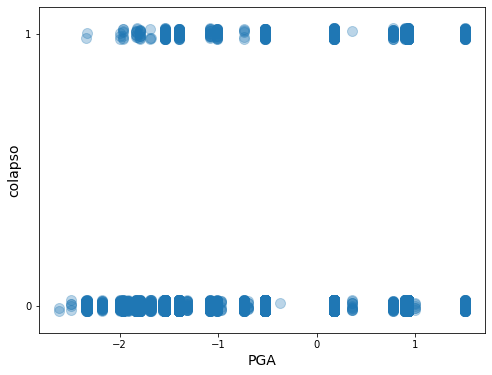

In [ ]:
# Ploteo del dataset del modelo 1
fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
e_plot = st.uniform.rvs(size=y.size, loc=-0.02, scale=0.04)
ax.scatter( x, y + e_plot, alpha=.3, s=100 )

# Formateo
ax.set_yticks([0,1])
ax.set_xlabel('PGA', fontsize=14)
ax.set_ylabel('colapso', fontsize=14)
ax.set_ylim([-0.1,1.1]);

In [ ]:
# modelo 1
xtest = np.arange( x.min(), 3, 0.1 )
with pm.Model() as model:
    
    X = pm.MutableData( 'X', x )

    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*x )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Bernoulli( "y", p=p, observed=y )

    # Posterior de los parámetros
    trace_ej11 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.set_data( {'X':xtest} )
    pm.sample_posterior_predictive( trace_ej11, extend_inferencedata=True, var_names=['p'] )

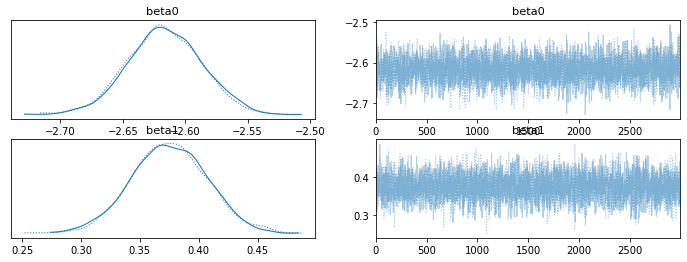

In [ ]:
az.plot_trace( trace_ej11, var_names=['~p','~logitp'] );

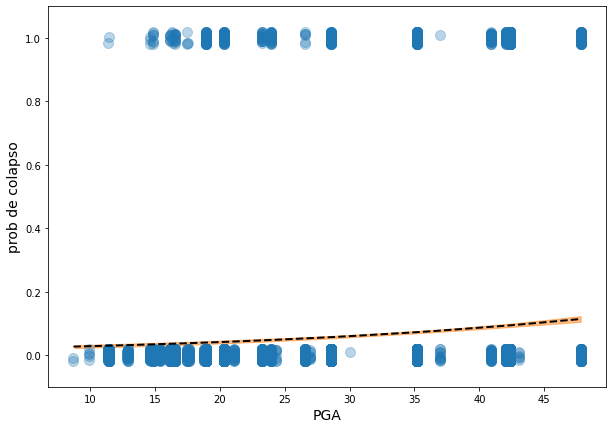

In [ ]:
# Ploteo de predicciones de p del modelo 1
fig, ax = plt.subplots( figsize=(10,7) )

# Re-escalado de x para ploteo
xplot = x * df_haiti_clean['PGA'].std() + df_haiti_clean['PGA'].mean()

# Línea media de p
ix = np.argsort(x)
ax.plot( xplot[ix], trace_ej11.posterior['p'].mean(['chain','draw'])[ix],'k--',
         linewidth=2, label='_nolegend_')

# HDI de p
az.plot_hdi( xplot, trace_ej11.posterior['p'], color='C1', ax=ax )

# Observaciones
ax.scatter( xplot, y + e_plot, alpha=.3, s=100 )

# Formateo
# ax.set_yticks([0,1])
ax.set_xlabel('PGA', fontsize=14)
ax.set_ylabel('prob de colapso', fontsize=14)
ax.set_ylim([-0.1,1.1]);

In [ ]:
# modelo 2
x3 = df_haiti_clean['suelo_cat'].to_numpy()
with pm.Model() as model_2:

    X = pm.MutableData( 'X', x )

    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5, shape=4 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5, shape=4 )

    # Mean
    logitp = pm.Deterministic( "logitp", beta0[ x3 ] + beta1[ x3 ]*X )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )

    # Modelo
    Y = pm.Bernoulli( "y", p=p, observed=y )

    # Posterior de los parámetros
    trace_ej14 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej14, extend_inferencedata=True )

In [ ]:
# Ploteo de predicciones del modelo 2
fig, ax = plt.subplots( figsize=(8,6) )

# Re-escalado de x para ploteo
xplot = x * df_haiti_clean['PGA'].std() + df_haiti_clean['PGA'].mean()

# Línea media de p
for i in range( trace_ej14.posterior.dims['beta0_dim_0'] ):

    # Línea media
    ix = np.argsort(xplot[x3==(i+1)])
    ax.plot( xplot[x3==(i+1)][ix], trace_ej14.posterior['p'].mean(['chain','draw'])[x3==(i+1)][ix],'k--',
            linewidth=2, color='C'+str(i), label=df_haiti_clean['Nature du sol'].cat.categories[i] )
    
    # HDI de p
    az.plot_hdi( xplot[x3==(i+1)], trace_ej14.posterior['p'][:,:,x3==(i+1)], color='C'+str(i), ax=ax )

    # Observaciones
    ax.scatter( xplot[x3==(i+1)], y[x3==(i+1)] + e_plot[x3==(i+1)], alpha=.2, s=100, color='C'+str(i) )

# Formateo
ax.set_xlabel('PGA', fontsize=14)
ax.set_ylabel('prob de colapso', fontsize=14)
ax.set_ylim([-0.1,0.4])
ax.legend();

In [ ]:
# modelo 3
x2 = df_haiti_clean['Stories'].to_numpy()
with pm.Model() as model_2:
    
    X = pm.MutableData( 'X', x )

    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X + beta2*x2 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Bernoulli( "y", p=p, observed=y )

    # Posterior de los parámetros
    trace_ej12 = pm.sample( 3000, tune=2000, cores=1, chains=1 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej12, extend_inferencedata=True )

In [ ]:
# Modelo 4
x3 = df_haiti_clean['suelo_cat'].to_numpy()
with pm.Model() as model_3:

    X = pm.MutableData( 'X', x )

    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5, shape=3 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5, shape=3 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )

    # Mean
    logitp = pm.Deterministic( "logitp", beta0[ x3-1 ] + beta1[ x3-1 ]*X + beta2*x2)
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )

    # Modelo
    Y = pm.Bernoulli( "y", p=p, observed=y )

    # Posterior de los parámetros
    trace_ej13 = pm.sample( 3000, tune=2000, cores=1, chains=1 )
    
    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej13, extend_inferencedata=True )

In [ ]:
# Comparación de modelos
models_list = {'PGA':trace_ej11, 'PGA + suelo':trace_ej12,
               'PGA + pisos':trace_ej14, 'PGA + pisos + suelo':trace_ej13}
models_comp = az.compare( models_list )
az.plot_compare( models_comp )

## Ejemplo 0: dataset sintetico bi-variado

In [ ]:
# Dataset sintético
np.random.seed(1234)
N = 100
x1 = st.uniform.rvs( loc=-2, scale=4, size=N )
x2 = st.uniform.rvs( loc=-2, scale=4, size=N )
logitp = lambda x1, x2: 0.1 + 2.5*x1 + 1*x2 + 1.2*x2**2
p = 1 / (1+np.exp(-logitp(x1,x2)))
y = st.binom.rvs( 1, p, size=N )

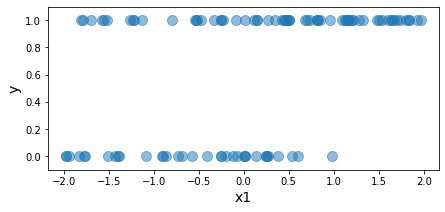

In [ ]:
# Plote de observaciones y vs x1
fig, ax = plt.subplots( figsize=(7,3) )

# Observaciones
ax.scatter( x1, y/1, alpha=.5, s=100 )

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_ylim([-0.1,1.1]);

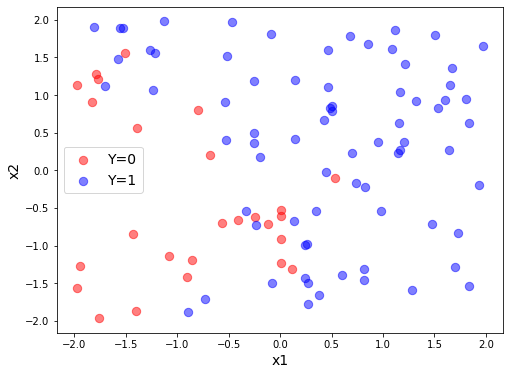

In [ ]:
# Ploteo de observaciones
coords = np.arange(-2,2,0.1)
x1test, x2test = np.meshgrid( coords, coords )
logitp_test = logitp( x1test, x2test )

fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x1[y==0], x2[y==0], c='r', label='Y=0', s=70, alpha=.5 )
ax.scatter( x1[y==1], x2[y==1], c='b', label='Y=1', s=70, alpha=.5 )

# p=0.5 curva real
CS = ax.contour( x1test, x2test, 1/(1+np.exp(-logitp_test)), [0.5], colors='k' )
ax.clabel( CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14)
ax.legend( fontsize=14 );

In [ ]:
# Modelo 1: y vs x1
with pm.Model() as model_01:
    
    X1 = pm.MutableData( 'X1', x1 )

    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X1 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=1, p=p, observed=y )

    # Posterior de los parámetros
    trace_ej01 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej01, extend_inferencedata=True )

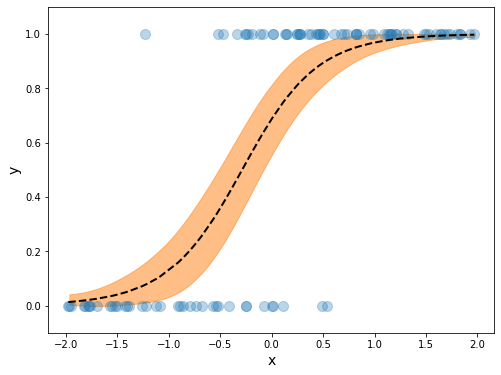

In [ ]:
# Resultados del modelo 1
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media de p
ix = np.argsort(x1)
ax.plot( x1[ix], trace_ej01.posterior['p'].mean(['chain','draw'])[ix],'k--',
         linewidth=2, label='_nolegend_')

# HDI de p
az.plot_hdi( x1, trace_ej01.posterior['p'], color='C1', ax=ax )

# Observaciones
ax.scatter( x1, y/1, alpha=.3, s=100 )

# Formateo
# ax.set_yticks([0,1])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_ylim([-0.1,1.1]);

In [ ]:
# Resultados y predicciones con p>=0.5
y_pred = (trace_ej01.posterior['p'].mean(['chain','draw'])>=0.5)*1
y_pred = y_pred.values

fig, ax = plt.subplots( figsize=(8,6) )

# Línea media de p
ix = np.argsort(x1)
ax.plot( x1[ix], trace_ej01.posterior['p'].mean(['chain','draw'])[ix],'k--',
         linewidth=2, label='_nolegend_')

# Observaciones
ax.scatter( x1[y_pred==0], y[y_pred==0], alpha=.3, s=100, c='r', label='y=0' )
ax.scatter( x1[y_pred==1], y[y_pred==1], alpha=.3, s=100, c='b', label='y=1' )

# Formateo
# ax.set_yticks([0,1])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-2.2,2.2])
ax.legend(fontsize=14)
# ax.set_title( 'predicciones' );

In [ ]:
# modelo 2: y ~ x1 + x2
with pm.Model() as model_02:
    
    X1 = pm.MutableData( 'X1', x1 )
    X2 = pm.MutableData( 'X2', x2 )
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X1 + beta2*X2 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=1, p=p, observed=y )

    # Posterior de los parámetros
    trace_ej02 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej02, extend_inferencedata=True )

In [ ]:
# Predicciones para xtest solo para plotear mejor
with model_02:
    # Posterior predictiva de y
    pm.set_data( {'X1':x1test.flatten(), 'X2':x2test.flatten()} )
    ppc_plot = pm.sample_posterior_predictive( trace_ej02, var_names=['p'] )

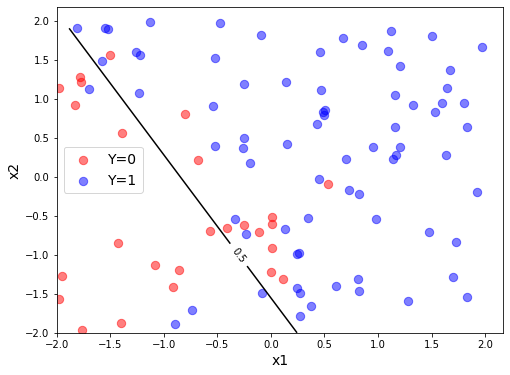

In [ ]:
# Ploteo de curva p=0.5 media
fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x1[y==0], x2[y==0], c='r', label='Y=0', s=70, alpha=.5 )
ax.scatter( x1[y==1], x2[y==1], c='b', label='Y=1', s=70, alpha=.5 )

# p media
p_mean = ppc_plot.posterior_predictive['p'].mean(['chain','draw']).values
CS = ax.contour( x1test, x2test, p_mean.reshape(40,40), [0.5], colors='k' )
ax.clabel( CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14)
ax.legend( fontsize=14 );

In [ ]:
# modelo 3: y ~ x1 + x2 + x2^2
with pm.Model() as model_03:
    
    X1 = pm.MutableData( 'X1', x1 )
    X2 = pm.MutableData( 'X2', x2 )
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )
    beta3 = pm.Normal( "beta3", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X1 + beta2*X2 + beta3*X2**2 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=1, p=p, observed=y )

    # Posterior de los parámetros
    trace_ej03 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej03, extend_inferencedata=True )

In [ ]:
# Solo para plotear mejor!
with model_03:
    # Posterior predictiva de y
    pm.set_data( {'X1':x1test.flatten(), 'X2':x2test.flatten()} )
    ppc_plot = pm.sample_posterior_predictive( trace_ej03, var_names=['p'] )

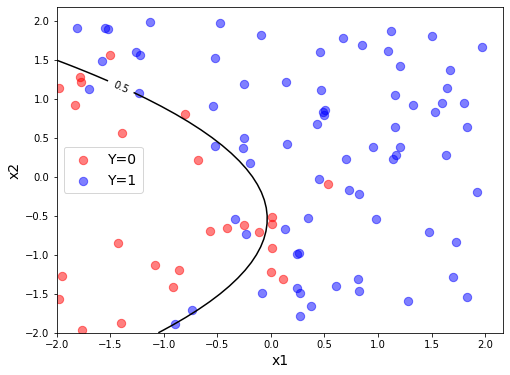

In [ ]:
# Ploteo de p=0.5
fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x1[y==0], x2[y==0], c='r', label='Y=0', s=70, alpha=.5 )
ax.scatter( x1[y==1], x2[y==1], c='b', label='Y=1', s=70, alpha=.5 )

# p media
p_mean = ppc_plot.posterior_predictive['p'].mean(['chain','draw']).values
CS = ax.contour( x1test, x2test, p_mean.reshape(40,40), [0.5], colors='k' )
ax.clabel( CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14)
ax.legend( fontsize=14 );

In [ ]:
# modelo 4: y ~ x1 + x1^2 + x1^3 + x2 + x2^2 + x2^3
with pm.Model() as model_04:
    
    X1 = pm.MutableData( 'X1', x1 )
    X2 = pm.MutableData( 'X2', x2 )
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )
    beta3 = pm.Normal( "beta3", mu=0, sigma=1.5 )
    beta4 = pm.Normal( "beta4", mu=0, sigma=1.5 )
    beta5 = pm.Normal( "beta5", mu=0, sigma=1.5 )
    beta6 = pm.Normal( "beta6", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X1 + beta5*X1**2 + beta6*X1**3 + beta2*X2 + beta3*X2**2 + beta4*X2**3 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=1, p=p, observed=y )

    # Posterior de los parámetros
    trace_ej04 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej04, extend_inferencedata=True )

In [ ]:
# Solo para plotear mejor!
with model_04:
    # Posterior predictiva de y
    pm.set_data( {'X1':x1test.flatten(), 'X2':x2test.flatten()} )
    ppc_plot = pm.sample_posterior_predictive( trace_ej04, var_names=['p'] )

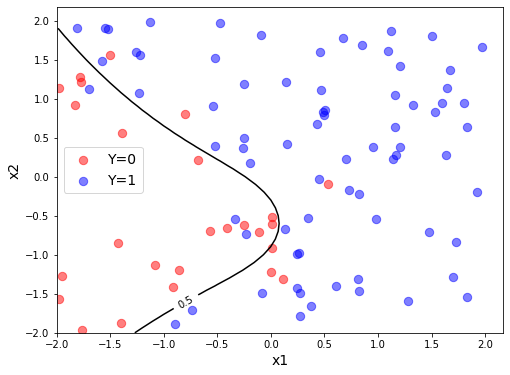

In [ ]:
# Ploteo de curva p=0.5
fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x1[y==0], x2[y==0], c='r', label='Y=0', s=70, alpha=.5 )
ax.scatter( x1[y==1], x2[y==1], c='b', label='Y=1', s=70, alpha=.5 )

# p media
p_mean = ppc_plot.posterior_predictive['p'].mean(['chain','draw']).values
CS = ax.contour( x1test, x2test, p_mean.reshape(40,40), [0.5], colors='k' )
ax.clabel( CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14)
ax.legend( fontsize=14 );

In [ ]:
# Comparación de modelos
models_list = {'p ~ x1':trace_ej01, 'p ~ x1 + x2':trace_ej02,
               'p ~ x1 + x2 + x2^2':trace_ej03, 'p ~ x1 + x1^2 + x1^3 + x2 + x2^2 + x2^3':trace_ej04}
models_comp = az.compare( models_list )
models_comp

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
p ~ x1 + x2 + x2^2,0,-28.690167,3.059870,0.000000,0.80608,4.538858,0.000000,False,log
p ~ x1 + x1^2 + x1^3 + x2 + x2^2 + x2^3,1,-29.857244,5.232683,1.167077,0.19392,5.319208,2.028628,True,log
p ~ x1 + x2,2,-36.463923,2.604213,7.773756,0.00000,5.072345,3.440231,False,log
p ~ x1,3,-43.681047,1.687334,14.990880,0.00000,5.063011,4.307930,False,log


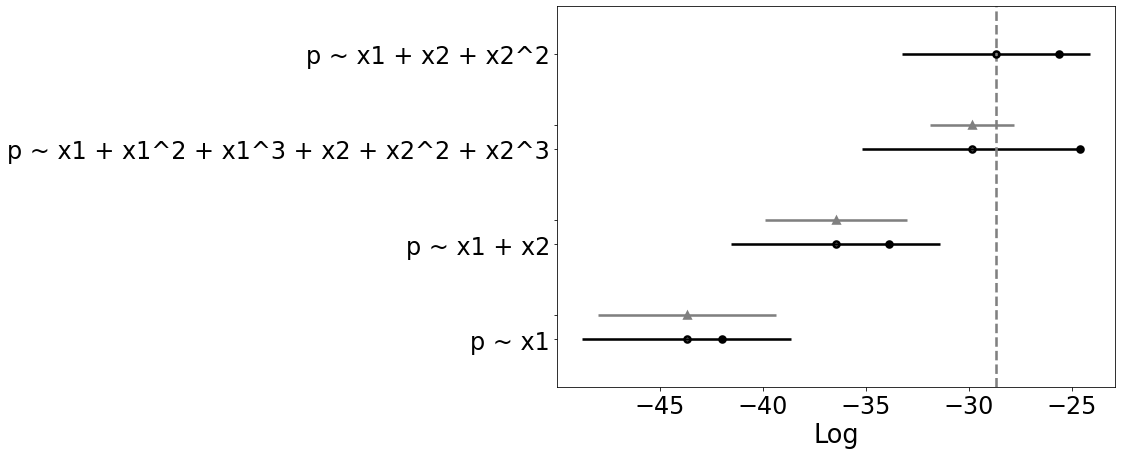

In [ ]:
az.plot_compare( models_comp, figsize=(10,7) )

## Ejemplo 2: Dataset binomial

In [ ]:
np.random.seed(1234)
N = 30
x = st.uniform.rvs( loc=-2, scale=4, size=N )
logitp = lambda x: 0.3 + 1.5*x
p = 1 / (1+np.exp(-logitp(x)))
y = st.binom.rvs( 10, p, size=N )

Text(0, 0.5, 'y/n')

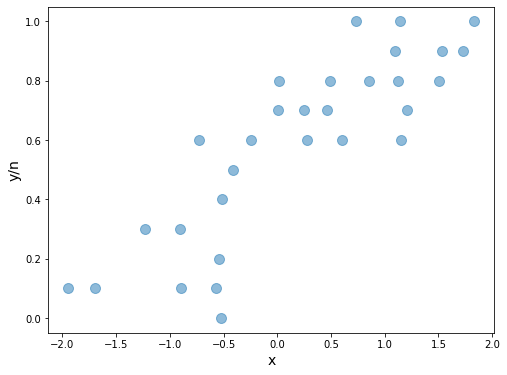

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x, y/10, alpha=.5, s=100 )

# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y/n', fontsize=14)
# ax.set_ylim([-0.1,1.1]);

In [ ]:
with pm.Model() as model_21:
       
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*x )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=10, p=p, observed=y )

    # Posterior de los parámetros
    trace_ej21 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej21, extend_inferencedata=True )

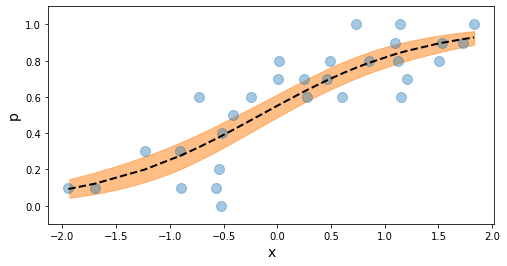

In [ ]:
fig, ax = plt.subplots( figsize=(8,4) )

# Línea media de p
ix = np.argsort(x)
ax.plot( x[ix], trace_ej21.posterior['p'].mean(['chain','draw'])[ix],'k--',
         linewidth=2, label='_nolegend_')

# HDI de p
az.plot_hdi( x, trace_ej21.posterior['p'], color='C1', ax=ax )

# Observaciones
ax.scatter( x, y/10, alpha=.4, s=100 )

# Formateo
# ax.set_yticks([0,1])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('p', fontsize=14)
ax.set_ylim([-0.1,1.1]);

In [ ]:
xbin = np.hstack( [xi*np.ones(10) for xi in x] )
ybin = np.hstack( [ np.hstack([np.ones(yi),np.zeros(10-yi)]) for yi in y] )

In [ ]:
with pm.Model() as model_22:
       
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*xbin )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Bernoulli( "y", p=p, observed=ybin )

    # Posterior de los parámetros
    trace_ej22 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej22, extend_inferencedata=True )

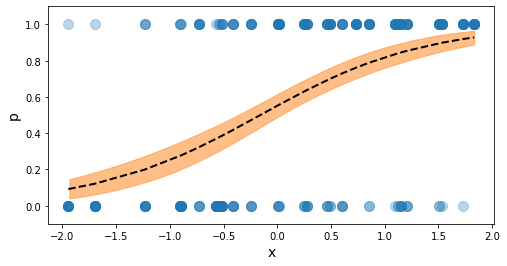

In [ ]:
fig, ax = plt.subplots( figsize=(8,4) )

# Línea media de p
ix = np.argsort(xbin)
ax.plot( xbin[ix], trace_ej22.posterior['p'].mean(['chain','draw'])[ix],'k--',
         linewidth=2, label='_nolegend_')

# HDI de p
az.plot_hdi( xbin, trace_ej22.posterior['p'], color='C1', ax=ax )

# Observaciones
ax.scatter( xbin, ybin, alpha=.3, s=100 )

# Formateo
# ax.set_yticks([0,1])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('p', fontsize=14)
ax.set_ylim([-0.1,1.1]);

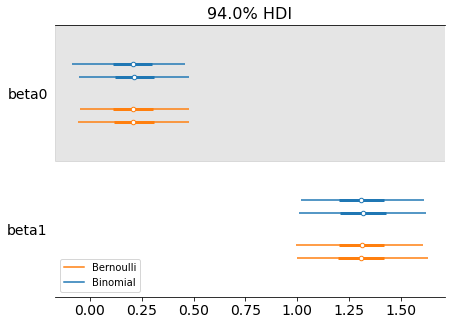

In [ ]:
az.plot_forest( [trace_ej21, trace_ej22], var_names=['~p','~logitp'],
                figsize=(7,5), model_names=['Binomial','Bernoulli'] );

In [ ]:
models_list = {'binomial':trace_ej41, 'bernoulli':trace_ej42}
models_comp = az.compare( models_list )
models_comp

ValueError: ignored

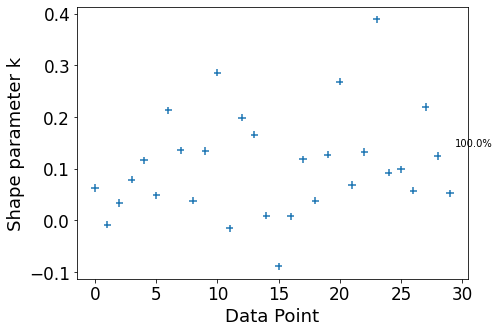

In [ ]:
loo_t = az.loo( trace_ej41, pointwise=True)
az.plot_khat(loo_t, show_bins=True, figsize=(7,5) );

## Ejemplo 3: Curvas de fragilidad en filipinas

In [ ]:
df_typhoon_0 = df_typhoon[ df_typhoon['Wind speed']<200]
df_typhoon_0 = df_typhoon_0[ df_typhoon_0['Wind speed']>50]
x = df_typhoon_0['Wind speed'].to_numpy()
x = (x-x.mean())/x.std()
y = df_typhoon_0['Completely damaged (abs.)'].to_numpy()
n = df_typhoon_0['Total # of houses'].astype('int').to_numpy()

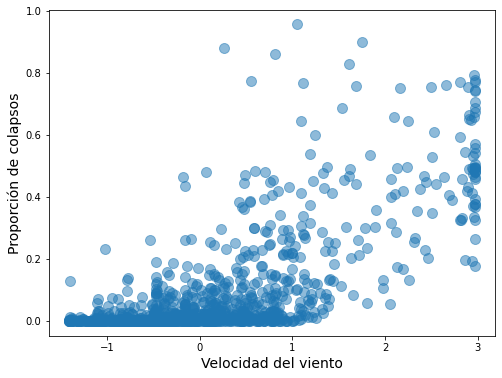

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x, y/n, alpha=.5, s=100 )

# Formateo
# ax.set_yticks([0,1])
ax.set_xlabel('Velocidad del viento', fontsize=14)
ax.set_ylabel('Proporción de colapsos', fontsize=14);

In [ ]:
# modelo 1
with pm.Model() as model_31:
    
    X = pm.MutableData( 'X', x )
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=n, p=p, observed=y )

    # Posterior de los parámetros
    trace_ej31 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej31, extend_inferencedata=True )

In [ ]:
# Para ploteo
xtest = np.arange( x.min(), 5, 0.1 )
with model_31:
    pm.set_data( {'X':xtest} )
    ppc_plot = pm.sample_posterior_predictive( trace_ej31, var_names=['p'] )

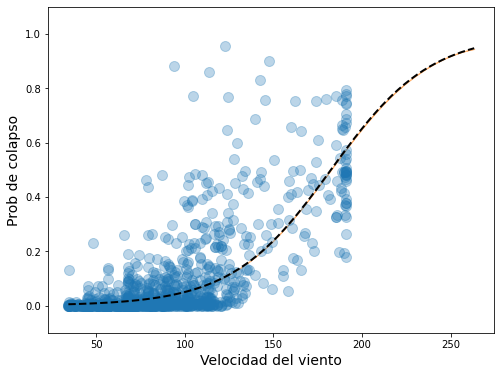

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Re-escalado de x para ploteo
xplot = x * df_typhoon['Wind speed'].std() + df_typhoon['Wind speed'].mean()
xtest_plot = xtest * df_typhoon['Wind speed'].std() + df_typhoon['Wind speed'].mean()

# Línea media de p
ax.plot( xtest_plot, ppc_plot.posterior_predictive['p'].mean(['chain','draw']),'k--',
         linewidth=2, label='_nolegend_')

# HDI de p
az.plot_hdi( xtest_plot, ppc_plot.posterior_predictive['p'], color='C1', ax=ax )

# Observaciones
ax.scatter( xplot, df_typhoon_0['perc. of completely damage'], alpha=.3, s=100 )

# Formateo
ax.set_xlabel('Velocidad del viento', fontsize=14)
ax.set_ylabel('Prob de colapso', fontsize=14)
ax.set_ylim([-0.1,1.1]);

In [ ]:
df_typhoon_0.head()

,pcode,Completely damaged (abs.),perc. of completely damage,Total # of houses,Wind speed,Distance to typhoon,Poverty incidence,% strong roof type,% strong wall type,Experience on typhoon damage,Region,Pro_code,disaster_name,N of mun per pro,N of typhoons per pro,Unnamed: 15,n typhons per mun,total,average n of typhoons per province
0,PH013306000,1,0.000111,8986.749801,40.0,202.583547,0.1209,0.978894,0.791426,0.000857,north luzon,PH0133,Bopha,57,6,0.105263,3,183,3.210526
1,PH071201000,1,0.000380,2634.999996,60.0,85.760891,0.1594,0.917328,0.591232,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000
2,PH071209000,10,0.001467,6815.250001,50.0,135.961942,0.4545,0.784594,0.428937,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000
3,PH071220000,1,0.000278,3590.999970,60.0,96.612433,0.3060,0.977943,0.652687,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000
4,PH071221000,1,0.000224,4468.999977,50.0,116.637440,0.2961,0.912750,0.634500,0.000457,central,PH0712,Bopha,8,1,0.125000,1,8,1.000000


In [ ]:
# modelo 2
x2 = df_typhoon_0['Poverty incidence'].to_numpy()
x2 = (x2-x2.mean())/x2.std()
with pm.Model() as model_32:
    
    X1 = pm.MutableData( 'X1', x )
    X2 = pm.MutableData( 'X2', x2 )

    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X1 + beta2*X2 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=n, p=p, observed=y )

    # Posterior de los parámetros
    trace_ej32 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej32, extend_inferencedata=True )

In [ ]:
models_list = {'modelo 1':trace_ej31, 'modelo 2':trace_ej32}
models_comp = az.compare( models_list, ic='loo' )
models_comp

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterio

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
modelo 2,0,-506957.151920,3471.891718,0.000000,0.5,40890.698901,0.000000,True,log
modelo 1,1,-587836.322697,2835.654935,80879.170778,0.5,45481.783610,16616.843116,True,log


/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


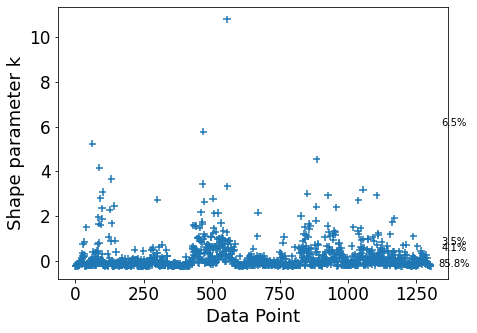

In [ ]:
loo_t = az.loo( trace_ej31, pointwise=True)
az.plot_khat(loo_t, show_bins=True, figsize=(7,5) );

## Ejemplo 4: Poisson

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove 

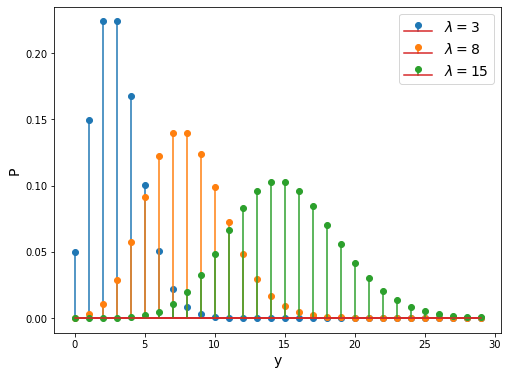

In [65]:
x = np.arange( 30 )
y = lambda mu: st.poisson.pmf( x, mu )

fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.stem( x, y(3), linefmt='C0-', markerfmt='C0o', label=r'$\lambda=3$' )
ax.stem( x, y(8), linefmt='C1-', markerfmt='C1o', label=r'$\lambda=8$' )
ax.stem( x, y(15), linefmt='C2-', markerfmt='C2o', label=r'$\lambda=15$' )

# Formateo
ax.set_xlabel('y', fontsize=14)
ax.set_ylabel('P', fontsize=14)
ax.legend( fontsize=14 );

In [5]:
# Nuevo dataframe
df_chile_eqs = pd.DataFrame()
df_chile_eqs['mag'] = df_chile['mag'].value_counts().index

# Cantidad de sismos totales por magnitud
counts = []
counts_sum = []
for i in range( len(df_chile_eqs) ):
   counts += [np.sum(df_chile['mag']==df_chile_eqs['mag'][i])]
   counts_sum += [np.sum(df_chile['mag']>=df_chile_eqs['mag'][i])]

df_chile_eqs['counts'] = counts
df_chile_eqs['counts_cum'] = counts_sum

df_chile_eqs.head()

,mag,counts,counts_cum
0,4.6,73,329
1,4.7,47,256
2,4.8,40,209
3,4.9,33,169
4,5.0,22,136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


Text(0, 0.5, 'Ocurrencias en 50 años')

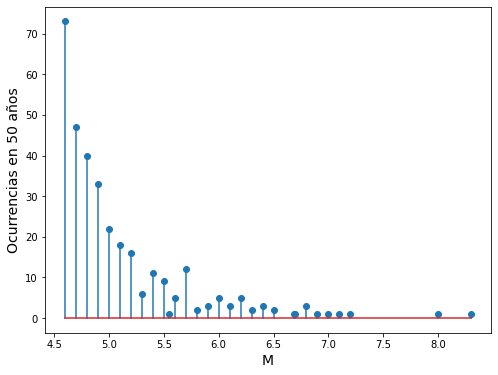

In [6]:
x = df_chile_eqs['mag'].to_numpy()
y = df_chile_eqs['counts'].to_numpy()

fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.stem( x, y )

# Formateo
ax.set_xlabel('M', fontsize=14)
ax.set_ylabel('Ocurrencias en 50 años', fontsize=14)

In [68]:
# modelo 1
with pm.Model() as model_51:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=3, sigma=5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=2 )
    
    # Mean
    logl = pm.Deterministic( "logl", beta0 + beta1*x )
    l = pm.Deterministic( "l", pm.math.exp(np.log(50) + logl) )
    
    # Modelo
    Y = pm.Poisson( "y", l, observed=y )

    # Posterior de los parámetros
    # trace_ej51 = pm.sample( 3000, tune=2000, cores=2 )

    # priori checks
    prior_checks = pm.sample_prior_predictive(samples=100) 

    # Posterior predictiva de y
    # pm.sample_posterior_predictive( trace_ej51, extend_inferencedata=True )

Text(0, 0.5, 'tasa media anual de ocurrencia')

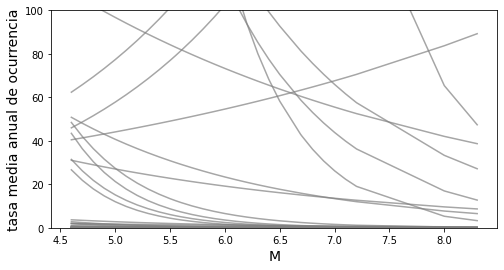

In [69]:
fig, ax = plt.subplots( figsize=(8,4) )

# Línea media de p
ix = np.argsort(x)
ax.plot( x[ix], prior_checks.prior['l'][0,0:100,:].T[ix], color='gray', alpha=.7 )

# sns.kdeplot( prior_checks.prior['l'][0,:,10], ax=ax )

# Observaciones
# ax.stem( x, y )

# Formateo
ax.set_ylim([0,100])
ax.set_yscale('linear')
ax.set_xlabel('M', fontsize=14)
ax.set_ylabel('tasa media anual de ocurrencia', fontsize=14)

In [49]:
# modelo 1
with pm.Model() as model_50:
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1 )
    
    # Mean
    logl = pm.Deterministic( "logl", beta0 )
    l = pm.Deterministic( "l", pm.math.exp(logl) )
    
    # Modelo
    Y = pm.Poisson( "y", l, observed=y )

    # priori checks
    prior_checks_0 = pm.sample_prior_predictive(samples=100000) 

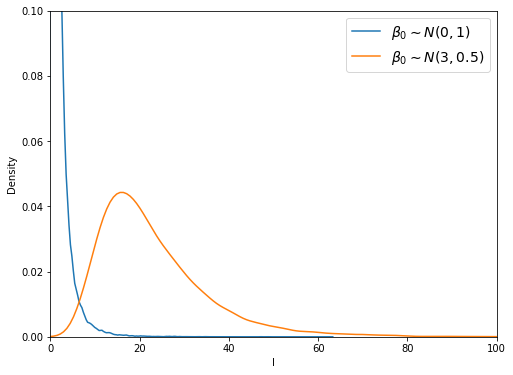

In [53]:
fig, ax = plt.subplots( figsize=(8,6) )

sns.kdeplot( prior_checks_0.prior['l'][0,:], label=r'$\beta_0 \sim N(0,1)$' )
sns.kdeplot( prior_checks_1.prior['l'][0,:], label=r'$\beta_0 \sim N(3,0.5)$' )

ax.set_xlim([0,100])
ax.set_ylim([0,0.1])
ax.legend( fontsize=14 )

Text(0, 0.5, 'tasa media anual de ocurrencia')

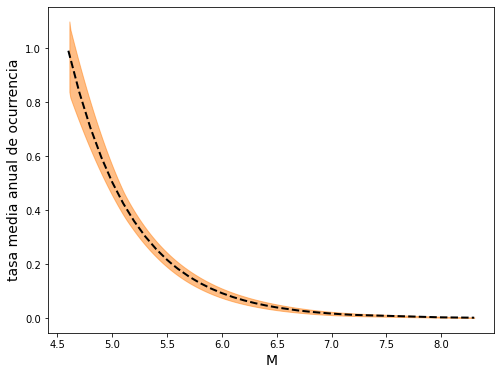

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media de p
ix = np.argsort(x)
ax.plot( x[ix], np.exp(trace_ej51.posterior['logl'].mean(['chain','draw']))[ix],'k--',
         linewidth=2 )

# HDI de p
az.plot_hdi( x, np.exp(trace_ej51.posterior['logl']), color='C1', ax=ax )

# Observaciones
# ax.stem( x, y )

# Formateo
# ax.set_yticks([0,1])
ax.set_yscale('linear')
ax.set_xlabel('M', fontsize=14)
ax.set_ylabel('tasa media anual de ocurrencia', fontsize=14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


Text(0, 0.5, 'Ocurrencias de M>m en 50 años')

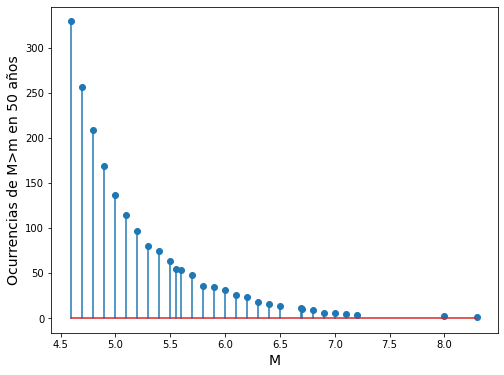

In [ ]:
x = df_chile_eqs['mag'].to_numpy()
y = df_chile_eqs['counts_cum'].to_numpy()

fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.stem( x, y )

# Formateo
ax.set_xlabel('M', fontsize=14)
ax.set_ylabel('Ocurrencias de M>m en 50 años', fontsize=14)

In [ ]:
# modelo 2
with pm.Model() as model_52:
    
    # Priors
    a = pm.Normal( "a", mu=0, sigma=1.5 )
    b = pm.Normal( "b", mu=0, sigma=1.5 )
    
    # Mean
    logl = pm.Deterministic( "logl", a + b*x )
    l = pm.Deterministic( "l", 10**(np.log10(50) + logl) )
    
    # Modelo
    Y = pm.Poisson( "y", l, observed=y )

    # Posterior de los parámetros
    trace_ej52 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej52, extend_inferencedata=True )

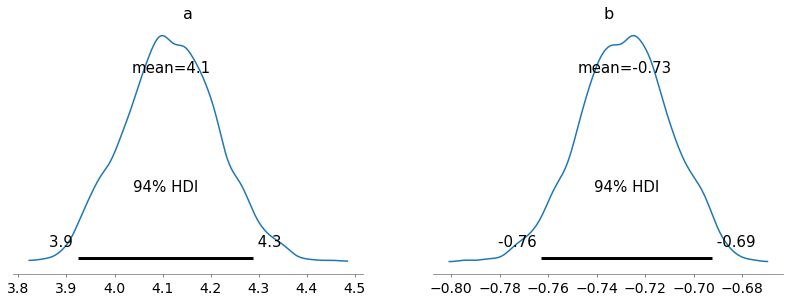

In [ ]:
az.plot_posterior( trace_ej52, var_names=['~logl','~l']);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


Text(0, 0.5, 'Ocurrencias en 50 años')

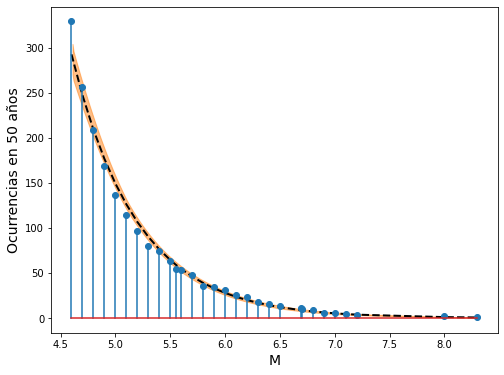

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media de p
ix = np.argsort(x)
ax.plot( x[ix], trace_ej52.posterior['l'].mean(['chain','draw'])[ix],'k--',
         linewidth=2 )

# HDI de p
az.plot_hdi( x, trace_ej52.posterior['l'], color='C1', ax=ax )

# Observaciones
ax.stem( x, y )

# Formateo
# ax.set_yticks([0,1])
ax.set_yscale('linear')
ax.set_xlabel('M', fontsize=14)
ax.set_ylabel('Ocurrencias en 50 años', fontsize=14)

In [ ]:
# modelo 3
with pm.Model() as model:
    
    # Priors
    a = pm.Normal( "a", mu=0, sigma=2 )
    b = pm.Normal( "b", mu=0, sigma=2 )
    sigma = pm.Exponential( "sigma", 1 )
    
    # Mean
    mu = pm.Deterministic('mu', np.log10(50) + a + b * x )  
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=sigma, observed=np.log10(y) )
      
    # Posterior de los parámetros
    trace_ej53 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_ej53, extend_inferencedata=True )

ERROR:pymc:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


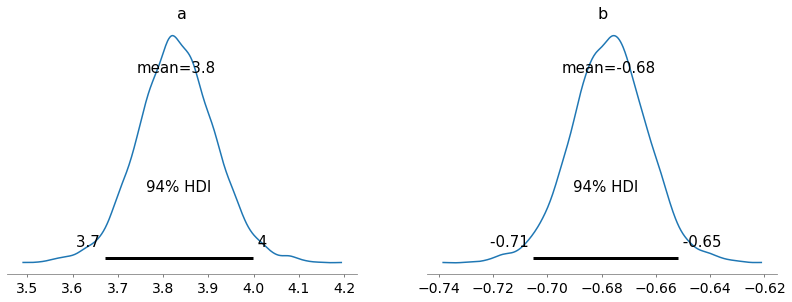

In [ ]:
az.plot_posterior( trace_ej53, var_names=['~mu','~sigma']);

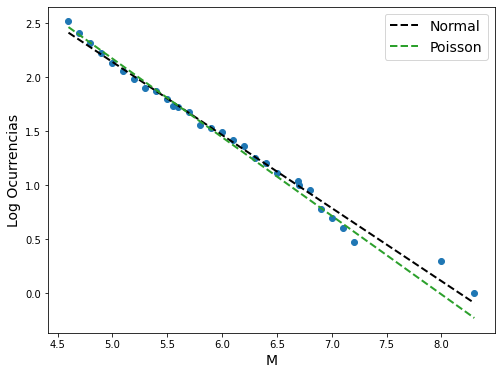

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Línea media de p
ix = np.argsort(x)
ax.plot( x[ix], trace_ej53.posterior['mu'].mean(['chain','draw'])[ix],'k--',
         linewidth=2, label='Normal' )

ax.plot( x[ix], np.log10(50) + trace_ej52.posterior['logl'].mean(['chain','draw'])[ix],'C2--',
         linewidth=2, label='Poisson' )

# HDI de p
# az.plot_hdi( x, trace_ej53.posterior['mu'], color='C1', ax=ax )
# az.plot_hdi( x, np.log10(50) + trace_ej52.posterior['logl'], color='C2', ax=ax )

# Observaciones
ax.scatter( x, np.log10(y) )

# Formateo
# ax.set_yticks([0,1])
ax.set_yscale('linear')
ax.set_xlabel('M', fontsize=14)
ax.set_ylabel('Log Ocurrencias', fontsize=14)
ax.legend( fontsize=14 );

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f95a3d25090>],
      dtype=object)

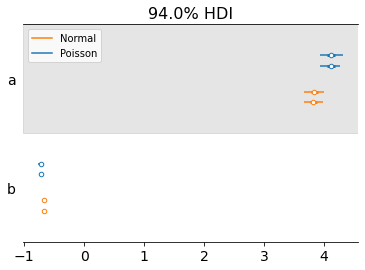

In [ ]:
az.plot_forest( [trace_ej52, trace_ej53], model_names=['Poisson','Normal'],
                var_names=['a','b'], figsize=(6,4))

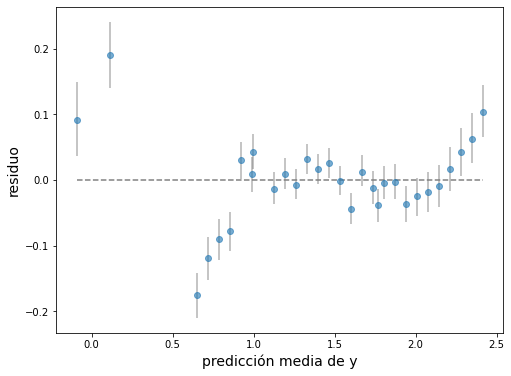

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )

# Residuos
residuals = np.log10(y) - trace_ej53.posterior['mu']

# Predicción posterior media de y
mu_mean = trace_ej53.posterior['mu'].mean( ['chain','draw'] ).to_numpy()

# Intervalos de confianza
residuals_hdi = az.hdi( residuals, hdi_prob=0.9 )
residuals_mean = residuals.mean(['chain','draw'])

# Gráfico
if not ax:
  fig, ax = plt.subplots( figsize=(7,7) )

# Residuos
ax.hlines( y=0, xmin=mu_mean.min(), xmax=mu_mean.max(),
            colors='grey', linestyle='--' )
ax.errorbar( mu_mean, residuals_mean,
              yerr=np.abs( residuals_mean-residuals_hdi )['mu'].T,
              fmt='C0o',
              ecolor='grey', alpha=.6 )

# Formateo
ax.set_xlabel('predicción media de y', fontsize=14)
ax.set_ylabel('residuo', fontsize=14);
